#Reading the csv file


In [ ]:
import pandas as pd

df= pd.read_csv("Supermarket2.csv")
df.head()

,Unnamed: 0,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,0,750-67-8428,Helioples,Cairo,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,1,226-31-3081,mamoura,Alex,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,2,631-41-3108,Helioples,Cairo,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,3,123-19-1176,Helioples,Cairo,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,4,373-73-7910,Helioples,Cairo,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


#check the data


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1000 non-null   int64  
 1   Invoice ID               1000 non-null   object 
 2   Branch                   1000 non-null   object 
 3   City                     1000 non-null   object 
 4   Customer type            1000 non-null   object 
 5   Gender                   1000 non-null   object 
 6   Product line             1000 non-null   object 
 7   Unit price               1000 non-null   float64
 8   Quantity                 1000 non-null   int64  
 9   Tax 5%                   1000 non-null   float64
 10  Total                    1000 non-null   float64
 11  Date                     1000 non-null   object 
 12  Time                     1000 non-null   object 
 13  Payment                  1000 non-null   object 
 14  cogs                     

#check duplicated

In [ ]:
df.duplicated().any()

False

# 1.Calculate total profit for each branch


##python code

In [ ]:
Branches_profit = df.groupby('Branch')['gross income'].sum()
Max_profit = Branches_profit.max()
Max_profit_branch = Branches_profit.idxmax()
print(f"Highest branch is ({Max_profit_branch}),And its value is ({Max_profit})")

Highest branch is (mamoura),And its value is (5265.1765)


##SQL code

In [ ]:
SELECT Branch, SUM(gross_income) AS Total_profit
FROM Supermarket2
GROUP BY Branch
HAVING SUM(gross_income) = (
    SELECT MAX(Total_profit)
    FROM (
        SELECT SUM(gross_income) AS Total_profit
        FROM Supermarket2
        GROUP BY Branch
    ) AS branch_profit
);

# 2. Analyze sales Quantity and total for product lines


##python code

In [ ]:
Branches_Quantity=df.groupby(["Branch",'Product line'])['Quantity'].sum().reset_index()
max_product_line_quantity = Branches_Quantity.groupby('Branch').apply(lambda x: x.sort_values('Quantity', ascending=False).head(2)).reset_index(drop=True)
Branches_Total=df.groupby(["Branch",'Product line'])['Total'].sum().reset_index()
max_product_line_total = Branches_Total.groupby('Branch').apply(lambda x: x.sort_values('Total', ascending=False).head(2)).reset_index(drop=True)
print(f"max Branches_Quantity \n{max_product_line_quantity}\nmax Branches_Total\n {max_product_line_total}")

max Branches_Quantity 
        Branch         Product line  Quantity
0    Helioples   Home and lifestyle       371
1    Helioples    Sports and travel       333
2      mamoura   Food and beverages       369
3      mamoura  Fashion accessories       342
4  zouni beach    Sports and travel       322
5  zouni beach    Health and beauty       320
max Branches_Total
         Branch         Product line       Total
0    Helioples   Home and lifestyle  22417.1955
1    Helioples    Sports and travel  19372.6995
2      mamoura   Food and beverages  23766.8550
3      mamoura  Fashion accessories  21560.0700
4  zouni beach    Sports and travel  19988.1990
5  zouni beach    Health and beauty  19980.6600


##SQL code

In [ ]:
WITH Ranked_Quantity AS (
    SELECT Branch,  Product_line,  SUM(Quantity) AS Total_Quantity,
           RANK() OVER (PARTITION BY Branch ORDER BY SUM(Quantity) DESC) AS Quantity_Rank
    FROM Supermarket2
    GROUP BY Branch, Product_line
),

Ranked_Total AS (
    SELECT Branch, Product_line, SUM(Total) AS Total_Sales,
           RANK() OVER (PARTITION BY Branch ORDER BY SUM(Total) DESC) AS Sales_Rank
    FROM Supermarket2
    GROUP BY Branch, Product_line
)

SELECT RQ.Branch,RQ.Product_line,RQ.Total_Quantity,RT.Total_Sales
FROM Ranked_Quantity AS RQ
JOIN Ranked_Total AS RT ON RQ.Branch = RT.Branch AND RQ.Product_line = RT.Product_line
WHERE RQ.Quantity_Rank = 1 OR RT.Sales_Rank <= 2;


# 3. Customer type and demographics


##python code

In [ ]:
customer_type = df.groupby(['Branch','Customer type' ])['Customer type'].count().unstack()
gender = df.groupby(['Branch', 'Gender'])['Gender'].count().unstack()
print(f"Customer Type :\n{customer_type}\nGender:\n{gender}")

Customer Type :
Customer type  Member  Normal
Branch                       
Helioples         167     173
mamoura           169     159
zouni beach       165     167
Gender:
Gender       Female  Male
Branch                   
Helioples       161   179
mamoura         178   150
zouni beach     162   170


##SQL code

In [ ]:
SELECT Branch,  Customer_type, COUNT(Customer_type) AS no_of_Customer_type
from Supermarket2
group by Branch,  Customer_type
order by Branch asc ;

SELECT Branch,  Gender, COUNT(Gender) AS no_of_Gender
from Supermarket2
group by Branch,  Gender
order by Branch asc;

# 4.Pricing margins and Payment methods


##python code

In [ ]:
pricing_margins = df.groupby('Branch')[['Unit price', 'gross margin percentage']].mean().reset_index()
payment_methods = df.groupby(['Branch', 'Payment'])['Payment'].count().unstack()
print(f"pricing_margins:\n{pricing_margins}\n\npayment_methods:\n{payment_methods}")

pricing_margins:
        Branch  Unit price  gross margin percentage
0    Helioples   54.780853                 4.761905
1      mamoura   56.609024                 4.761905
2  zouni beach   55.659277                 4.761905

payment_methods:
Payment      Cash  Credit card  Ewallet
Branch                                 
Helioples     110          104      126
mamoura       124           98      106
zouni beach   110          109      113


##SQL code


In [ ]:
SELECT Branch, avg (Unit_price)AS AVG_Unit_price,
       avg (gross_margin_percentage)AS AVG_gross_margin_percentage
from Supermarket2
group by Branch
order by Branch asc ;

SELECT Branch,  Payment, count(Payment) AS Payment_methods
from Supermarket2
group by Branch, Payment
order by Branch asc;

##power BI visualize
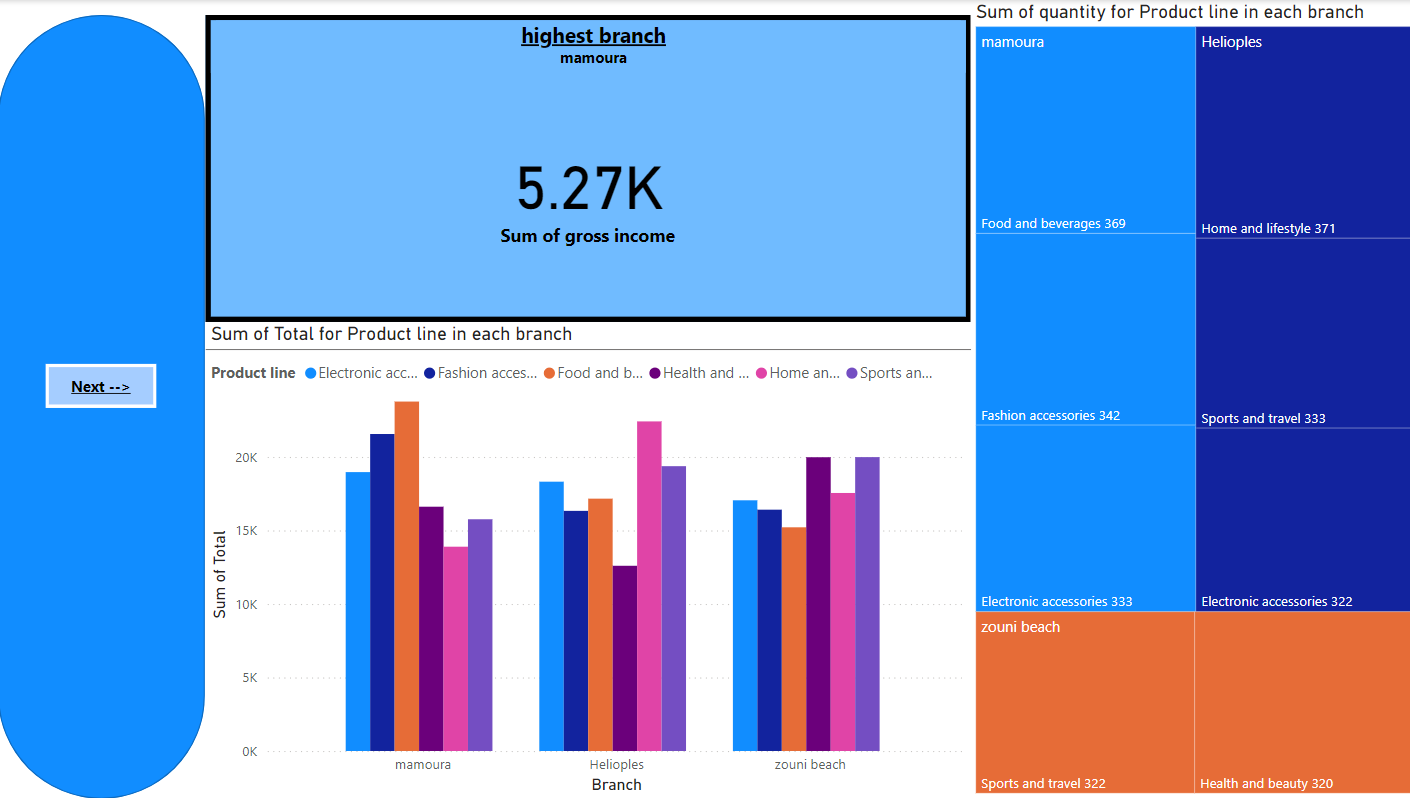

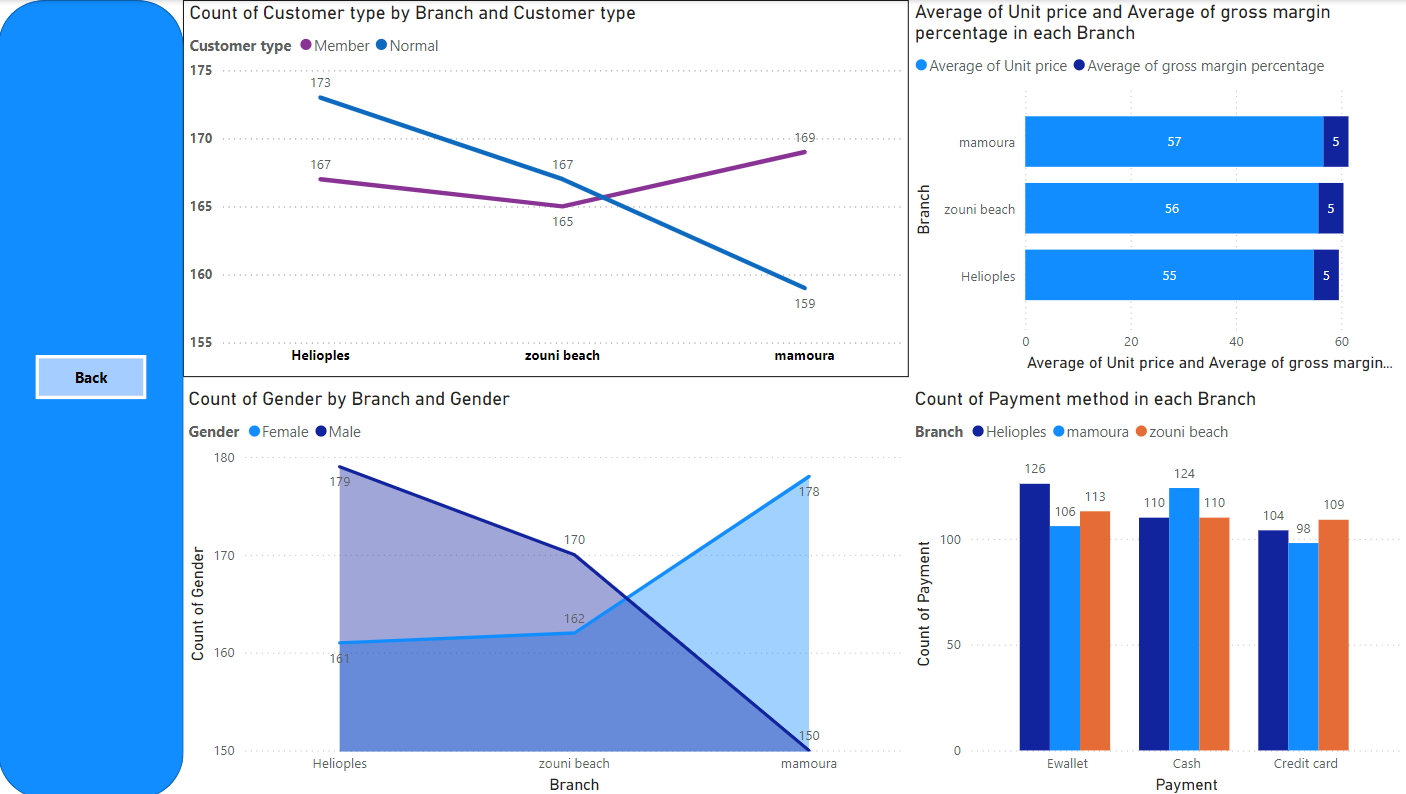

#####excel visualize
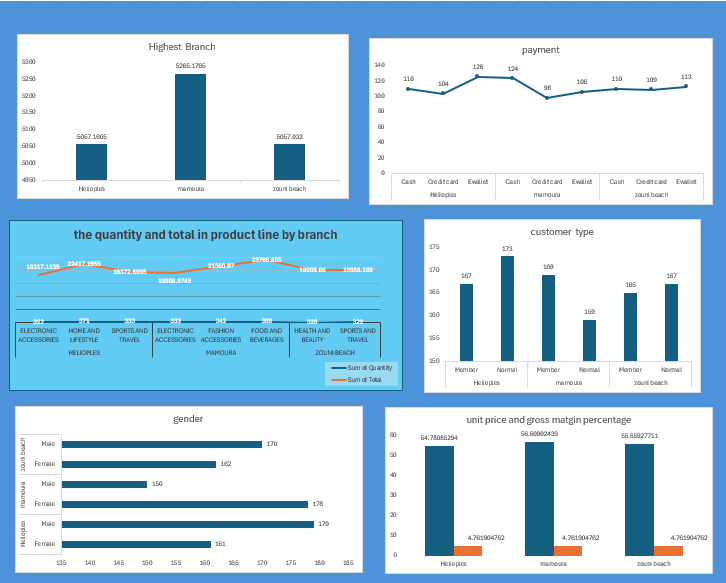

#######Recommendations to Increase Profits for Less Profitable Branches:

1. Enhance Product Line Offerings:
   - Analyze which product lines generate higher revenues and ensure they are well-stocked and promoted.
   - Introduce or promote high-revenue product lines such as Food and beverages and Fashion accessories in less profitable branches.

2. Customer Engagement and Membership Programs:
   - Encourage more customers to become members, as members tend to spend more.
   - Implement loyalty programs and targeted promotions to retain customers and increase repeat purchases.

3. Targeted Marketing Campaigns:
   - Use customer data to tailor marketing campaigns, focusing on the most popular product lines and customer preferences.
   - Increase marketing efforts towards underperforming demographics (e.g., attracting more female customers if a branch has fewer).

4. Pricing Strategies:
   - Consider slight price adjustments or bundling offers to increase the average transaction value.
   - Promote high-margin products more aggressively.

5. Optimize Payment Methods:
   - Encourage digital payments by offering small discounts or cashback incentives for using Ewallet or credit cards, reducing cash handling costs and increasing convenience.
"""
